# Project 2 - Classification


## Section 1.0 The Problem: "Predicting Heavy vs Casual Music Streamers"

Music streaming platforms thrive on user engagement. Some listeners casually stream a few songs, while others are heavy users who spend hours listening every day. Identifying these groups can help platforms improve personalization, retention, and recommendations.

Our goal is to predict whether a user is a heavy listener or a casual listener based on their usage and demographic data.

Heavy User: Someone in the top 25% of minutes streamed per day.

Casual User: Someone in the bottom 25%.

This focuses on listening behavior, which aligns directly with the features of the dataset.

In [1]:
## Setup Code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns




## Section 1.1 Introducing the Data 

The data set that I will be using is the [Global Music Streaming Listener Preferences Analysis] (https://github.com/SDVNishant9/Global-Music-Streaming-Listener-Preferences-Analysis). 

This dataset is a collection of 5,000 users on different music streaming platforms and their preferences for different types of music based on many factors like preferred genres, preferred artists, preferred streaming platforms, country of residence, age, etc. This dataset does contain limitations as this data set was collected from a sample of 5,000 users which is a very small representation compared to the entire population that listens to music. This data is also only collected from streaming services so if a user only listens to music via Radio, they will not be included in this data set which can skew overall results.


In [2]:
music_data = pd.read_csv('Music_Preferences.csv')

# A quick look at the columns of the dataset
print(music_data.columns)


Index(['User_ID', 'Age', 'Country', 'Streaming Platform', 'Top Genre',
       'Minutes Streamed Per Day', 'Number of Songs Liked',
       'Most Played Artist', 'Subscription Type',
       'Listening Time (Morning/Afternoon/Night)',
       'Discover Weekly Engagement (%)', 'Repeat Song Rate (%)'],
      dtype='object')


In [3]:
# A quick look at the first 5 rows of the dataset
pd.set_option("display.width", 500)
print(music_data.head())

  User_ID  Age    Country Streaming Platform Top Genre  Minutes Streamed Per Day  Number of Songs Liked Most Played Artist Subscription Type Listening Time (Morning/Afternoon/Night)  Discover Weekly Engagement (%)  Repeat Song Rate (%)
0   U1000   34      Japan              Tidal    Reggae                       295                    138              Adele              Free                                Afternoon                           47.42                 16.74
1   U1001   24    Germany             Deezer   Country                        86                    388         Ed Sheeran           Premium                                    Night                           12.06                 69.25
2   U1002   49    Germany             Deezer       Pop                       363                    368        Post Malone           Premium                                Afternoon                           47.19                 67.38
3   U1003   55  Australia            YouTube    Reggae  

## Section 1.2 Preprocessing the Data

We want to preprocess the data to make sure that it is clean and ready to be used for the classification problem because if the data is not properly cleaned/preprocessed then the classification model will not be able to make accurate predictions and the results will not be reliable. 

In [4]:
# Determine top and bottom 25% thresholds for Minutes Streamed
threshold_high = music_data["Minutes Streamed Per Day"].quantile(0.75)
threshold_low = music_data["Minutes Streamed Per Day"].quantile(0.25)

# Assign labels
def usage_label(x):
    if x >= threshold_high:
        return "Heavy"
    elif x <= threshold_low:
        return "Casual"
    else:
        return None  # Exclude middle 50%

music_data["User_Type"] = music_data["Minutes Streamed Per Day"].apply(usage_label)

# Filter out middle 50%
filtered_data = music_data[music_data["User_Type"].isin(["Heavy", "Casual"])]

# Check distribution
print(filtered_data["User_Type"].value_counts())


User_Type
Casual    1253
Heavy     1250
Name: count, dtype: int64


Now that the data is preprocessed, we can move on to visualizating the data.

## Section 2.0 Visualizing the Data

Before building models, we must understand the data by visualizing it. Visualizations help us understand relationships between features and uncover trends that raw numbers either can’t show or make it very difficult to. For this project, since the main goal is to classify users as Free or Premium, so we need to look for patterns that could help predict subscription type.

To do this we wil use:

Pie Chart: to visualize the balance between Heavy and Casual listeners in the dataset.

Kernel Density Estimate: to compare the distribution of Minutes Streamed per Day across the listening types.

Histogram: to show the distribution of daily streaming minutes.



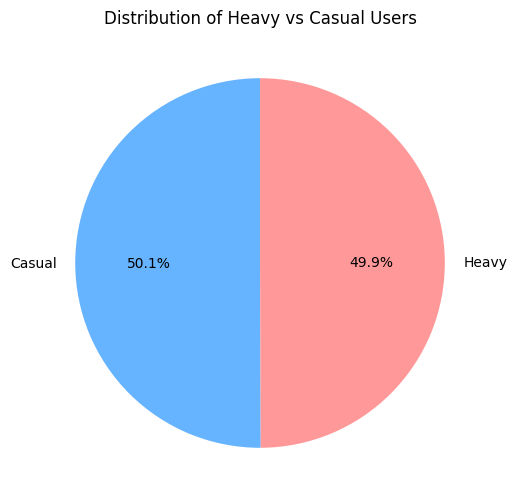

In [5]:


user_distribution = filtered_data["User_Type"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(
    user_distribution, 
    labels=user_distribution.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=["#66b3ff","#ff9999"]
)
plt.title("Distribution of Heavy vs Casual Users")
plt.show()


This pie chart shows the proportion of users classified as Heavy (top 75%) and Casual (bottom 25%). It shows the overall balance between the two groups which is , which is important for our classification problem. Knowing the prevalence of each class helps us understand whether the model might be biased toward one group and ensures we are aware of the dataset composition before modeling.

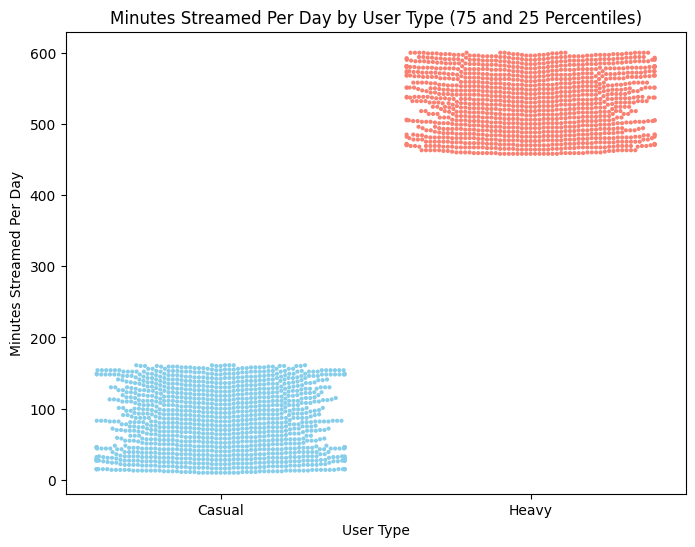

In [6]:
plt.figure(figsize=(8,6))
sns.swarmplot(data=filtered_data, x="User_Type", y="Minutes Streamed Per Day",hue="User_Type", palette=['skyblue','salmon'], size=3)
plt.title('Minutes Streamed Per Day by User Type (75 and 25 Percentiles)')
plt.xlabel('User Type')
plt.ylabel('Minutes Streamed Per Day')
plt.show()

The swarm plot displays individual users’ daily listening minutes for Heavy and Casual users. It shows that Heavy users generally listen more each day, while Casual users tend to listen less, but there is some overlap. This visualization highlights the spread of user behavior and supports why minutes streamed is an important feature for distinguishing between user types.

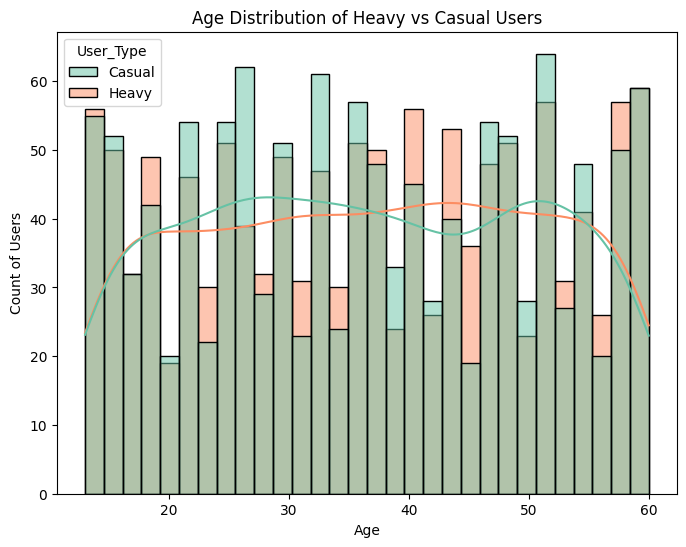

In [7]:
plt.figure(figsize=(8,6))
sns.histplot(data=filtered_data, x="Age", hue="User_Type", bins=30, kde=True, palette="Set2")
plt.title("Age Distribution of Heavy vs Casual Users")
plt.xlabel("Age")
plt.ylabel("Count of Users")
plt.show()


The histogram displays the raw counts of users across different daily streaming times. This visualization helps us see the spread of streaming behavior, showing that most users cluster below or around the cutoff, while some extreme users stream significantly more. It provides context for why the chosen threshold effectively separates Heavy from Casual listeners.

## Section 3.0 Modelling

To solve our classification problem of predicting whether a user is **Free** or **Premium**, we will test this by using three different classification algorithms:

1. **Logistic Regression**  
   - A simple, baseline model that estimates the probability of a class using a logistic function.  
   - Pros: Easy to implement, interpretable coefficients.  
   - Cons: Struggles with complex nonlinear relationships.  

2. **Decision Tree**  
   - A tree based model that splits the dataset into smaller subsets based on feature thresholds using root branch and leaf nodes.  
   - Pros: Intuitive and easy to visualize.  
   - Cons: Can easily overfit if not pruned.  

3. **Random Forest**  
   - An ensemble method that builds many decision trees and averages their predictions.  
   - Pros: More robust, reduces overfitting, usually better accuracy.  
   - Cons: Less interpretable than a single tree.  

We will train and evaluate each model using **accuracy** and a **classification report** (precision, recall, F1-score) to compare their performances as it relates to the data.

## Section 3.1 More Preprocessing and Training/Testing Split

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Features: Exclude 'Minutes Streamed Per Day' to avoid trivial prediction
X = filtered_data[["Age", "Number of Songs Liked",
                   "Discover Weekly Engagement (%)", "Repeat Song Rate (%)"]]


# Encode target
le = LabelEncoder()
y = le.fit_transform(filtered_data["User_Type"])  # Heavy=1, Casual=0

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Section 3.2 Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logreg = LogisticRegression(
    C=10.0,             # smaller
    max_iter=1000,       # allow more iterations for convergence
    solver='lbfgs',
    random_state=42
)

logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))



Logistic Regression Results
Accuracy: 0.5189620758483033
              precision    recall  f1-score   support

           0       0.52      0.51      0.52       251
           1       0.52      0.53      0.52       250

    accuracy                           0.52       501
   macro avg       0.52      0.52      0.52       501
weighted avg       0.52      0.52      0.52       501



The Logistic Regression model achieved slightly better than random accuracy (~51.9%), showing that it learned some patterns to distinguish Heavy vs Casual users, but the signal from features is weak.

- Precision and recall are balanced between the two classes (Heavy vs Casual), which indicates no severe bias toward either class.

- **F1-scores** around 0.52 reflect the model’s moderate ability to correctly classify users.

**Takeaway:** Logistic Regression captures some linear relationships between features like Number of Songs Liked, Repeat Song Rate, and Discover Weekly Engagement, but it struggles with non-linear interactions. This suggests that more complex models (like Random Forest or Gradient Boosting) could improve performance.

## Section 3.2 Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

dt = DecisionTreeClassifier(
    max_depth=None,          # allow full growth
    min_samples_split=2,     # split on even small groups
    min_samples_leaf=1,      # allow leaves with 1 sample
    random_state=42
)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Results")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Results
Accuracy: 0.5169660678642715
              precision    recall  f1-score   support

           0       0.52      0.51      0.51       251
           1       0.52      0.53      0.52       250

    accuracy                           0.52       501
   macro avg       0.52      0.52      0.52       501
weighted avg       0.52      0.52      0.52       501



The Decision Tree achieved an accuracy of ~51.7%, slightly above random guessing.

Precision and recall are nearly balanced across Heavy and Casual users, meaning the model does not favor one class.

F1-scores around 0.52 reflect moderate predictive ability.

Takeaway: The Decision Tree captures some non-linear patterns between features, but it still struggles to generalize due to the subtle differences in behavior between Heavy and Casual users. Ensemble methods like Random Forest or Gradient Boosting may improve performance by reducing overfitting and leveraging multiple weak learners.

## Section 3.3 Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=500,   # more trees
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1           # use all cores
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Results
Accuracy: 0.5289421157684631
              precision    recall  f1-score   support

           0       0.53      0.54      0.53       251
           1       0.53      0.52      0.52       250

    accuracy                           0.53       501
   macro avg       0.53      0.53      0.53       501
weighted avg       0.53      0.53      0.53       501



The Forest achieved an accuracy of ~52.9%, which is above random guessing and higher than both the Logistic Regression and Decision Tree.

- **Precision:** Heavy = 0.53, Casual = 0.53 — balanced between classes, indicating the model is not biased toward either group.

- **Recall:** Heavy = 0.52, Casual = 0.54 — the model captures both classes at roughly equal rates.

- **F1-scores:** Heavy = 0.52, Casual = 0.53 — moderate ability to correctly classify users based on the available features.

**Takeaway:**

Random Forest can capture non-linear relationships among features such as Number of Songs Liked, Repeat Song Rate, and Discover Weekly Engagement. The slightly higher accuracy over simpler models suggests that ensemble methods can leverage subtle interactions in the dataset. However the performance is still modest (~53%), showing that the features provide only weak predictive signals.

## Section 4: Storytelling

Imagine a music streaming service trying to understand its users: some are heavy listeners, spending hours each day discovering new songs and curating playlists, while others are casual listeners, only tuning in occasionally. Our goal was to classify users into these two groups based on their behavior which can impact larger things like personilzed recommendations and algorithms within these platforms.

From the dataset we noticed some common patterns: heavy users tend to like more songs, engage more with personalized recommendations, and sometimes repeat songs less often because they explore more. Casual users, in contrast, have shorter daily listening times and smaller engagement with recommendations.

**When we trained our models:**

- Logistic Regression captured some linear trends (e.g., heavy users having slightly higher likes and engagement), achieving around 51–52% accuracy.

- Decision Tree modeled some non-linear patterns but only matched Logistic Regression’s performance (~51%).

- Random Forest, which combines multiple trees to capture more subtle interactions, reached ~53% accuracy.

These results tell a story: there is some signal in user behavior, but it is subtle. No model could perfectly separate heavy from casual listeners, reflecting the fact that user habits overlap significantly. For example, a casual user on certain days might binge-listen and resemble a heavy user, and vice versa.

**Key insight:** While the models cannot perfectly predict who is heavy or casual, they highlight behavioral trends: heavy users are slightly more engaged and explore more content, while casual users stick to familiar tracks. This suggests that streaming platforms could roughly identify heavy listeners for personalized experiences, but they would need additional features or better data for higher-confidence targeting.



## Section 5.0 Impact

This project provides both practical and ethical implications to the real world:

**Positive impact:**

- Streaming services can use insights to better personalize content for users, improve recommendations, and tailor promotions for heavy listeners.

- Identifying heavy users could inform subscription incentives, improving user satisfaction and retention.

**Potential risks/negatives:**

- Misclassifying users could lead to unfair targeting, such as over-promoting premium features to casual users or ignoring certain user segments.

- Using behavioral data for monetization raises privacy concerns, especially if sensitive demographic or device information is later incorporated.

- Over-reliance on algorithms without transparency could create biases in content exposure or engagement.

- Small sample size which could lead to overfitting and lack of generalization.

**Critical takeaway:**

Predictive modeling in user behavior can be valuable, but models must be evaluated carefully, and decisions based on these predictions should consider fairness, transparency, and user privacy.



## Section 5.1 Conclusion

In this project, we explored music streaming behavior to classify users as Heavy or Casual listeners. By analyzing features like minutes streamed, number of songs liked, repeat song rate, and engagement with recommendations, we tried multiple models including Logistic Regression, Decision Tree, and Random Forest. While the models only performed slightly better than random guessing, they revealed subtle patterns in user behavior and highlighted the challenges of predicting habits from limited data. Overall, this project showed that even with modest predictive power, data analysis can provide useful insights about user engagement and suggest directions for future research or feature collection.

## Section 6: References

1. [Global Music Streaming Listener Preferences Analysis](https://github.com/SDVNishant9/Global-Music-Streaming-Listener-Preferences-Analysis)
    - This is the original location in which I found the data set that I used in this project.
2. [ChatGPT](https://chat.openai.com/)
    - I used ChatGPT to help me with my research decisions such as which visualizations to use to best represent the data set in the manner I want, and what are the best training models to use that would provide the most accurate results with the data I was using in order to answer my classification question.
    - I used ChatGPT to help expand my knowledge of creating visualizations and models and to fine-tune them as much as possible to achieve the most accurate results. 